# SOLAR IV - Stellar Flares 

So far, we have been investigating solar activity with a focus on solar flares. However, we also know that other stars can also show similar behaviour, and this has become a rapidly growing field within astronomy. Therefore, in this session, we will focus on looking at stellar flares on stars outside our solar system!

<div class="alert alert-block alert-info">
    
**GOAL :** In this session, we are going to be using data from TESS, to investigate stellar flares on other stars. 

**AIM :** To understand how to access, manipulate and plot timeseries data of other stars from space-based missions. 

**OUTPUT :** Create light curve plots, determine the rotation period and activity levels for a sample of stars. 
</div>

To achieve our goals and aims, we will be using the Python package __[Lightkurve](https://lightkurve.github.io/lightkurve/index.html)__, which is a powerful tool for downloading, manipulating and analysing space-based data from missions such as Kepler and the Transiting Exoplanet Survey Satellite (TESS). 

If you haven't already, you can install the `lightkurve` Python package by running the bash command:
>`pip install lightkurve`

## Transiting Exoplanet Survey Satellite (TESS)

![title](TESS.png)

__[The Transiting Exoplanet Survey Satellite (TESS)](https://science.nasa.gov/mission/tess/)__ is a NASA mission launched in 2018 to search for planets around nearby, bright stars. It is the successor to the __[Kepler](https://science.nasa.gov/mission/kepler/mission)__, but is designed to observe nearly the entire sky. While TESS’s main goal is to find exoplanets, its continuous, precise light curves are also perfect for detecting stellar flares, pulsations, eclipses, and other variability, helping us learn more about stars themselves.

In the previous session, we looked at time series light curve data from X-ray and Extreme Ultraviolet instruments. Here, we will focus on using data from TESS, which observes in the visible wavelengths of the electromagnetic spectrum (i.e. what can be seen by the human eye).  

TESS has four identical, highly optimised, red-sensitive, wide-field cameras that together can monitor a 24-degree by 90-degree strip of the sky (see images above). By monitoring each strip for 27 days and nights (called a sector) at 2-second cadence, TESS will tile the southern and northern hemisphere sky year after year. Full details of the observational schedule can be found __[here](https://tess.mit.edu/observations/)__. 

**Note:** Please read/browse the information on the provided links, as this will give you a good overview of the mission before starting the Python work. Feel free to do your own reading and find out about Kepler as well!

***

### Accessing TESS data using lightkurve

First let's import some Python packages we will need, including lightkurve. 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import math

import lightkurve as lk

Lightkurve uses __[Astroquery](https://astroquery.readthedocs.io/en/latest/)__ to search for data products. Astroquery allows searches based on a target’s coordinates, catalog ID number, or name. This is passed into the search function using the target keyword, where there are many valid inputs, but we will use the name of the object as a string, for example, "AU Mic".

Below, we use the `search_lightcurve` function to find data for a well-known active star using its name and filtering by the mission TESS.

In [16]:
Target = "AU Mic"
search = lk.search_lightcurve(Target, mission="TESS")
print(search)

SearchResult containing 12 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 01 2018              SPOC     120   441420236      0.0
  1 TESS Sector 27 2020              SPOC      20   441420236      0.0
  2 TESS Sector 27 2020              SPOC     120   441420236      0.0
  3 TESS Sector 01 2018         TESS-SPOC    1800   441420236      0.0
  4 TESS Sector 27 2020         TESS-SPOC     600   441420236      0.0
  5 TESS Sector 01 2018               QLP    1800   441420236      0.0
  6 TESS Sector 27 2020               QLP     600   441420236      0.0
  7 TESS Sector 01 2018             TASOC     120   441420236      0.0
  8 TESS Sector 01 2018 GSFC-ELEANOR-LITE    1800   441420236      0.0
  9 TESS Sector 01 2018             TASOC    1800   441420236      0.0
 10 TESS Sector 01 2018           

As you can see, there are a number of data files avaliable from different authors and with varying cadence (i.e. exposure times). During this session, we will focus on using 2-min cadence (120 second exposure time) data, processed by the TESS __[Science Processing Operations Center (SPOC)](https://archive.stsci.edu/hlsp/tess-spoc)__. Therefore, we can filter our search further by including the `exptime` and `author` keywords. 

In [18]:
search_spoc = lk.search_lightcurve(Target, mission="TESS", author = "SPOC", exptime = 120)
print(search_spoc)

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120   441420236      0.0
  1 TESS Sector 27 2020   SPOC     120   441420236      0.0


Now we can see AU Mic has been observed by TESS in two different sectors, 1 and 27, which are separated by about 700 days (~ 2 years). You can see this in the year column, and for more information on the TESS observing strategy, see the links at the beginning of the notebook. 

We can download both of these and stitch them together, or we can work with only one sector. 

In [22]:
# You can download all light curves and stitch them together. 
lc_collection = search_spoc.download_all()
lc = lc_collection.stitch().remove_nans()

# Or you can select one to download.
lc_single= search_spoc[0].download(download_dir = 'add/here/').remove_nans()

We can then normalise and examine the light curve using the plot method.

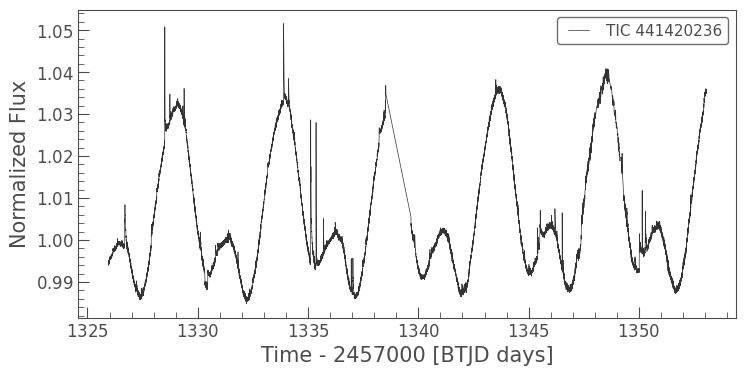

In [34]:
lc_norm = lc_single.normalize()
lc_norm.plot();
plt.show()

If required, you can also flatten the light curve to remove the sinusoidal trend. This is sometimes useful when identifying flares and searching for exoplanet transits. You can edit the `window_length` keyword to change the length of the filter window used. 

In [ ]:
lc_flat = lc_norm.flatten(window_length=401, polyorder=2)

## Task IV-1
- Create a normalised light curve plot for one TESS sector in 2-minute cadence of the star GJ 1243. 
- If there is more than one sector, create a second plot with all data stitched together and normalised. 

### Determining Stellar Rotation Periods

You may notice the sinusoidal pattern in the data. This is a result of star spots on the surface rotating in and out of view (see Figure below). Therefore, we can use these to estimate the stellar rotation period of the star.

In astronomy, a Lomb-Scargle Periodogram is a powerful statistical tool which can be used to search for periodic signals within time series data. Within the `lightkurve` package, there is a `to_periodogram()` function which can do this. 

You can also identify the highest peak using `period_at_max_power` and fold the data using `fold` to see how well it lines up. 

![title](Rotation.png)

## Task IV-2
- Estimate the stellar rotation period of the star using a single sector of TESS data.
- Plot the power spectrum.
- Fold and plot the light curve on the determined rotational period.
- Does everything line up? Is there anything you notice?

**Hint:** For some tips and pointers, see __[this guide](https://lightkurve.github.io/lightkurve/tutorials/3-science-examples/periodograms-creating-periodograms.html)__.

## Task IV-3 
- Repeat Task IV-2 using multiple sectors of TESS data.
- Is there a difference in the rotation period you obtain between using one sector of data and multiple sectors?
- Comment on your findings and suggest what could be happening?

<div class="alert alert-block alert-warning">
<b>CHECKPOINT 1:</b> Find a demonstrator and show them your rotation period plots, discussing what you have found, before progressing to the next task.
</div>

### Identifying Stellar Flares

While you have been analysing the stellar rotation period of your target star with TESS, you may have noticed there are many sharp peaks throughout the light curve. These are stellar flares which appear as sharp rises in brightness of the star, followed by a slow exponential decay (see diagram below). 

There are many different Python codes available which can identify and classify stellar flare events in time series observations. We will focus on using the __[Altaipony](https://altaipony.readthedocs.io/en/latest/index.html)__ Python package, which is a toolbox for statistical flare studies in photometric time series from Kepler, K2, and TESS, including flare search and characterisation. 

We import Altaipony: (can be installed as `pip install altaipony`)
>`from altaipony.flarelc import FlareLightCurve` 

To search for stellar flares, we can run the following on our TESS data obtained through lightkurve:

>`flc = FlareLightCurve(time=lc.time, flux=lc.flux, flux_err = lc.flux_err, mission = 'TESS')`

>`flcd = flc.find_flares()`

This will return the initial light curve with a new attribute - flares, which is a DataFrame containing columns of flare properties. Once we have a list of stellar flares, we can then examine their properties, such as duration and energy, and create a Cumulative Flare Frequency (CFF) plot, which shows how many flares of a particular energy you would expect to see on the star (see plot below). 

The flare properties we will be interested in are:
- `ampl_rec` - amplitude measured relative to the quiescent stellar flux
- `ed_rec` - equivalent duration of the flare (i.e. the area under the light curve)
- `tstart`, `tstop` - start and end of flare candidates
- `dur` - flare duration, which is tstop-tstart


![title](stellar_flares.png)

## Task IV-4 
Before we can identify any flares, we should remove the sinusoidal signal caused by the rotation of the star. To do this, we can use the flatten function (__[see here](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.flatten.html)__).

- Flatten the normalised light curve from Task IV-1 and plot.

**Note:** You may need to play around with the `window_length` keyword.

## Task IV-5
- Using Altaipony, identify all flares within the flattened light curve and print a Table of their properties.

**Hint:** For some tips and pointers, see __[this guide](https://altaipony.readthedocs.io/en/latest/tutorials/altai.html)__.

### Calculating Stellar Flare Energies

The energy of a flare is calculated using the equivalent duration (t), which represents the area under the flare light curve, as follows: 

###  $E_{flare} = L_{*} \times t$

We can then compare these flare energies to the solar flare classification as follows:
- **X10**: > 10<sup>32</sup> erg
- **X**: 10<sup>31</sup> – 10<sup>32</sup> erg
- **M**: 10<sup>30</sup> – 10<sup>31</sup> erg
- **C**: 10<sup>29</sup> – 10<sup>30</sup> erg
- **B**: 10<sup>28</sup> – 10<sup>29</sup> erg
- **A**: < 10<sup>28</sup> erg

## Task IV-6 
- If you assume the log luminosity of GJ 1243 in the TESS bandpass to be 31.06 erg/s, calculate the energy of the identified flares.
- Using the solar flare classification scheme above, what is the range in magnitude of the flares on GJ 1243?

## Task IV-7 
- Using the energies calculated in the previous task, plot the following distributions:
    - histogram plot of flare energy
    - Flare energy vs duration
- What can you say about the flare activity on GJ 1243?

<div class="alert alert-block alert-warning">
<b>CHECKPOINT 2:</b> Find a demonstrator and show them your flare statistics and plots for GJ 1243 and discuss what this shows.

## Task IV-8 (optional)
If you have completed all of the tasks and have remaining time, then you are now an expert in identifying and classifying stellar flares! 
You may want to consider further analysis, such as:

- Looking at other active stars such as Proxima Centauri, Barnard's Star or TRAPPIST-1.
- Looking at additional sectors of TESS data for GJ 1243. Is there a difference in flares between them?